# Physics 105 Problem Set 7: Python Component

## Welcome!

Today we're going to be looking at the two-body problem and scattering. In terms of python skills, this problem set is going to continue familiarizing you with using NumPy and matplotlib, as well as introduce you to SciPy.

**You should edit this Jupyter notebook to put your answers where indicated, evaluate all your code, and submit a PDF of your result on the bCourses assignment "Problem Set 7- Python"**

### SciPy

SciPy (https://docs.scipy.org/doc/scipy/) is one of the most widely used Python libraries out there. Unlike NumPy and Matplotlib, its contents are more specialized: it contains a scientific tools for optimization and root finding (scipy.optimize), integration and ODE solving (scipy.integrate), interpolation (scipy.interpolate), and a wide range of other applications. Many of SciPy's methods wrap FORTRAN or C, making them much faster than anything you can write in native Python. Today the library we will be using is scipy.integrate, whose ODE solvers are immensely useful for solving equations of motion.

## Problem 1. The radial equation

In class and in the textbook, you've encountered how a two-body problem for two objects with masses $m_1$ and $m_2$ with positions $\vec{r}_1$ and $\vec{r}_2$ can be written in the center of mass frame as an equation of motion for a single separation vector $\vec{r}$,
$$
    \mu \ddot{\vec{r}} = F(r) \hat{r},
$$
where $\mu = m_1 m_2 / (m_1 + m_2)$ is the reduced mass and $F(r) \hat{r}$ is the force; and that, as discussed in detail in Taylor chapter 8, this can be simplified into an equation in terms of the azimuthal angle $\phi$ rather than time,
$$
    u''(\phi) + u(\phi) = - \frac{\mu}{\ell^2 u^2(\phi)} F, \quad \text{(Taylor 8.41)}
$$
where we have introduced $u(\phi) \equiv 1/r(\phi)$ and the angular momentum $\ell$.

In this problem, were going to learn how to use SciPy's ODE solver to solve the above 1D differential equation, and see what happens as we try different values of the force $F(r)$.

### (a) Newtonian gravity

To warm up, let's consider Newtonian gravity, in which case
$$
    F = - \frac{\gamma}{r^2} = - \gamma u^2
$$
For this problem, consider the constants
$$
\begin{split}
    \gamma &= 0.1 
    \\
    \mu &= 1
\end{split}
$$
and the initial conditions
$$
\begin{split}
    r(0) &= 1
    \\
    \dot r(0) &= 0
    \\
    r(0) \dot \phi(0) &= 0.1 \implies \ell = 0.1.
\end{split}
$$
Then the equation of the orbit Taylor 8.41 gives
$$
    u''(\phi) = 10 - u.
$$
For this problem, we're going to look at how to solve this equation using `scipy.integrate.solve_ivp`. `solve_ivp` is an extremely useful function for solving initial value problems of the form
$$
    \frac{d \vec{y}(t)}{d t} = f(t, \vec{y})
$$
i.e., an ODE. `solve_ivp` takes as its arguments the function `f(t, y)`, the range `t_span` in $t$ over which to solve the equation, and the initial value `y0` that the function takes. There are also a variety of useful named arguments, including the solver used, the points `t_eval` at which to evaluate the solution, and the absolute and relative tolerances `atol` and `rtol`. `solve_ivp` returns an object containing an array named `t` for the points in $t$ where the solution is evaluated and `y` for the points in $y$.

While the above equation makes it *look* like we might only be able to solve a first order ODE, this is not in fact the case. To solve a higher order ODE, we simply make the velocity and other higher derivatives part of the vector $y$. For our orbital equation, for instance, we can write
$$
    \vec{y}(\phi) =  \begin{pmatrix} u(\phi) \\ u'(\phi) \end{pmatrix} \implies \frac{d\vec{y}}{d \phi} = \frac{d}{d \phi} \begin{pmatrix} u(\phi) \\ u'(\phi) \end{pmatrix} = \begin{pmatrix} u'(\phi) \\ 10 - u(\phi)
    \end{pmatrix}
$$
which is totally equivalent to what we had before.

Let's see this in action! The following code is an example of how to use solve_ivp, but where I've changed some of the parameters. You can see that sol contains attributes `sol.t` corresponding to the points in $\phi$ where the equation has been solved, and `sol.y`, correspondng to the values of $y = (u, u')$ at those points. We observe that `sol.y` has shape `(2, sol.t.size)`; to get just the values of $u(\phi)$, we can look at `sol.y[0]`.

**For this problem, I want you to**
1. Edit the following code to reflect the initial parameters and initial conditions, and solve for $u(\phi)$ for 10000 evenly spaced points over the range $\phi \in [0, 12 \pi)$.
2. Determine the period of oscillation of $r$ w.r.t. $\phi$. To do this, you might e.g. look at where $u$ (or $r$) goes from increasing to decreasing or vice versa. Print your result below.
3. Make a plot of $r$ (not $u$) vs. $\phi$, with $\phi$ on the $x$ axis, showing two full periods of the orbit. Make sure your axes are labeled and the whole range is clearly visible.
4. Make a plot of the trajectory of the orbit in the CM frame. I.e., plot $x = r \cos \phi$ on the $x$-axis against $y = r \sin \phi$ on the $y$-axis for two full periods of the orbit. Make sure your axes are visible and your whole plot range is clearly visible.

In [116]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

def f(phi, y):
    '''The RHS of the ODE. Here y = (u, up); returns a vector dy_dt = (up, upp) containing the first
    derivative of y.
    You will need to edit this example so that the parameters reflect those in the problem statement.
    '''
    u, up = y
    upp = 20 - u
    dy_dt = (up, upp)
    return dy_dt

phi_num = 10000
phi_eval = np.linspace(0,6*np.pi,num=phi_num)
sol = integrate.solve_ivp(
    f, 
    t_span=(phi_eval[0], phi_eval[-1]), 
    y0=(5,0), 
    t_eval=phi_eval,
    rtol=1.e-8, 
    atol=1.e-8
)
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.885e-03 ...  1.885e+01  1.885e+01]
        y: [[ 5.000e+00  5.000e+00 ...  5.000e+00  5.000e+00]
            [ 0.000e+00  2.828e-02 ... -2.828e-02  1.258e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1214
     njev: 0
      nlu: 0


### (b) Non-newtonian corrections

Now let's consider the leading relativistic corrections to the force. General relativity ends up adding a correction to the force,
$$
    F(r) = - \frac{\gamma}{r^2} - 3 \gamma \frac{\ell^2}{\mu^2 c^2 r^4}
$$
Take the same initial conditions as in the previous part, and again take $\gamma = 0.1, \mu = 1, \ell = 0.1$; and let's consider this all to be in units where $c = 10$.

**For this problem,**
1. Below the problem statement, write the equations of motion including the new relativistic term as a Markdown LaTeX equation.
2. In the code block below, use `scipy.integrate.solve_ivp` as before to set up and solve the equations of motion for $u(\phi)$ including the new term; solve for 10000 evenly spaced points over the range $\phi \in [0, 12 \pi)$.
3. Use your result to numerically determine the period of the orbit with respect to the angle $\phi$. What is the difference $\Delta \phi$ between this period and the one you found in the previous section?
4. Plot the first two full periods of $r$ vs. $\phi$, with $r$ on the $y$-axis and $\phi$ on the $x$-axis. Check that the plot matches the period you found.
5. Plot the first five periods of the orbit in space, i.e. plot $x = r \cos \phi$ vs. $y = r \sin \phi$ as in part (a).

In all plots, make sure to label your axes and add a legend.

In [52]:
# Your code here

## Problem 2: Scattering

For this problem, we're now going to consider a 2D scattering problem like the one you saw in this week's Problem 2 on the written homework. This problem will have you practice solving an ODE in two dimensions rather than just one. We will consider the case that one of the two particles is much heavier than the other, in which case the lab frame is the center of mass frame. This is the case with e.g. Rutherford scattering.

### (a) Repulsive potential

Consider a particle with mass $m = 1$ with initial position and velocity
$$
\begin{split}
    x(0) &= - 10
    \\
    y(0) &= b
    \\
    \dot x(0) &= 1
    \\
    \dot y(0) &= 0
\end{split}
$$
Here $b$ is called the "impact parameter". This particle encounters a repulsive potential $U(\vec{r}) = k |\vec{r}|^{-2}$ in terms of a position $\vec{r}$ from the origin, which results in a force
$$
    \vec{F}(\vec{r}) = \frac{2 k \vec{r}}{|\vec{r}|^4} 
$$
We will take $k = 0.1$. The equations of motion are thus
$$
    \ddot{\vec{r}} =  \frac{0.2 \vec{r}}{|\vec{r}|^4} 
$$
**For this problem,**
Use `scipy.integrate.solve_ivp` to set up the two-dimensional initial value problem for the particle, with the given initial position and velocity. Based on the discussion in Problem 1, the RHS of your ODE `f(t,y)` will need to take a vector `y` with *four* components (think about why). Then
1. Solve for the trajectory of the particle in $x$ and $y$ for each of $b \in \{ 0.1, 0.2, 0.5, 1\}$. Evaluate over 10000 evenly spaced points in time running from $t = 0$ to $t = 200$.
2. Make a single plot showing the trajectory in space for all the different impact parameters. Show the $x$-position on the $x$-axis and the $y$-position on the $y$-axis. Make sure to make a legend labelling each individual curve with its impact parameter $b$. Set your plot limits as $x, y \in (-10, 10)$.
3. Underneath the curves you plotted in part 2, add dashed lines emanating from the origin at the angle $\theta = \pi \left(1 - \frac{b}{\sqrt{b^2 + \frac{k}{E}}}\right)$ that you computed in 2.a. on the written problem set, where $E = \frac{1}{2} m v(0)^2$ and $k = 0.1$ as above. Check that these roughly match the slope of the curves you found numerically.

Here is an example of the sort of plot you should make:

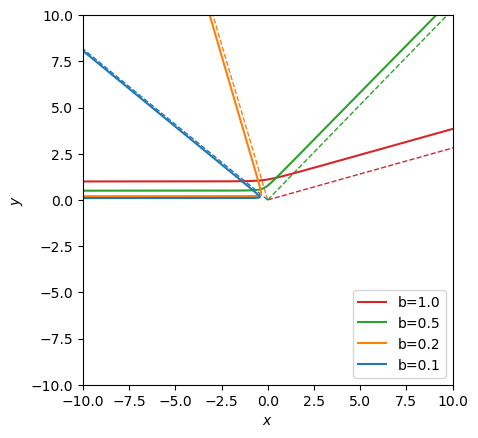

In [1]:
# Your code here

### (b) Attractive potential

For this part, now consider the case that the potential is attractive, $U = - k |\vec{r}|^{-2}$, which flips the sign on the force:
$$
F(\vec{r}) = - \frac{2 k \vec{r}}{|\vec{r}|^4}
$$

**For this problem,**
Repeat the same steps as in the previous part, but now for the attractive potential and for impact parameters (0.1,0.5,1,2). That is, for the same initial conditions as in part (a), use `scipy.integrate.solve_ivp` to set up the two-dimensional initial value problem for the particle, with the given initial position and velocity. Then
1. Solve for the trajectory of the particle in $x$ and $y$ for each of $b \in \{ 0.1, 0.5, 1, 2\}$. Evaluate over 10000 evenly spaced points in time running from $t = 0$ to $t = 200$.
2. Make a single plot showing the trajectory in space for all the different impact parameters. Show the $x$-position on the $x$-axis and the $y$-position on the $y$-axis. Make sure to make a legend labelling each individual curve with its impact parameter $b$. Set your plot limits as $x, y \in (-10, 10)$.
3. Don't plot the dashed lines representing the angles for this part.


In [ ]:
# Your code here